# Autoregressive Flows 

1.  The Core Idea: The Autoregressive Property

The foundation of autoregressive models is the **chain rule of probability**. For any ordering of the dimensions of a vector $\mathbf{x}=(x_1,\dots,x_D)$, the joint probability can be factored into a product of one-dimensional conditional probabilities:

$$p(x_1,\dots,x_D)=\prod_{i=1}^{D}p(x_i|x_1,\dots,x_{i-1})$$

This powerful rule tells us that we can model a complex, high-dimensional joint distribution by breaking it down into a sequence of simpler, one-dimensional conditional distributions. Each variable $x_i$ only needs to be conditioned on the variables that came before it in the chosen sequence.

Our goal is to design a normalizing flow that explicitly respects this conditional structure, allowing for very expressive transformations.

2.  Masked Autoregressive Flow (MAF)

This type of flow is specifically designed for **fast likelihood evaluation**.

### Theory

A Masked Autoregressive Flow (MAF) defines a transformation where the parameters for transforming a latent variable $z_i$ into a data variable $x_i$ depend on the **previous data dimensions** $x_{1:i-1}$.

* **Forward Transformation (Sampling):** The mapping from the latent space to the data space is defined as: $x_i=h(z_i,g_i(x_{1:i-1},w_i))$. Here, $g_i$ is the conditioner network that computes the parameters (e.g., scale and shift) for the simple, invertible coupling function $h$ (like the affine transformation from RealNVP).
* **Inverse Transformation (Likelihood):** The mapping from the data space to the latent space is: $z_i=h^{-1}(x_i,g_i(x_{1:i-1},w_i))$

### The Critical Asymmetry (MAF)

The way MAF is structured creates a crucial performance asymmetry:

* **Likelihood Calculation (Fast):** To evaluate the likelihood of a given data point $\mathbf{x}$, we need to compute its corresponding $\mathbf{z}$. Since all components $(x_1,\dots,x_D)$ are known, we can compute all the conditioner outputs $g_i(x_{1:i-1})$ in parallel. Once the scale and shift parameters for every dimension are ready, all the inverse transformations $h^{-1}$ to find each $z_i$ can also be performed **in parallel**. This makes likelihood evaluation very efficient.
* **Sampling (Slow):** To generate a new sample $\mathbf{x}$, we must proceed **sequentially**. We sample the full vector $\mathbf{z}$ from the base distribution. Then:
    * We compute $x_1$ from $z_1$ (since it depends on no prior dimensions).
    * We use this new $x_1$ to compute the parameters for the transformation of $z_2$, giving us $x_2$.
    * We use $x_1$ and $x_2$ to compute parameters for $z_3$, giving us $x_3$.
    * ...and so on. This is an inherently serial process ($x_1 \rightarrow x_2 \rightarrow \dots \rightarrow x_D$) and can be very slow for high-dimensional data.

### Implementation Concept: Masking

The main implementation challenge is to compute all conditioner outputs $g_i(x_{1:i-1})$ efficiently. Instead of using $D$ separate neural networks, a single, larger network is used with carefully constructed **binary masks** on its weights. This is the core idea of the **MADE (Masked Autoencoder for Distribution Estimation)** architecture.

By assigning a "degree" to each neuron and masking connections to ensure a neuron can only receive input from neurons of a lower degree, the network can compute all conditional parameters in a single forward pass while strictly enforcing the autoregressive property.

3.  Inverse Autoregressive Flow (IAF)

This type of flow is the inverse of MAF and is designed for **fast sampling**.

### Theory

An Inverse Autoregressive Flow (IAF) defines a transformation where the parameters for generating $x_i$ depend on the **previous latent dimensions** $z_{1:i-1}$.

* **Forward Transformation (Sampling):** $x_i=h(z_i,g_i(z_{1:i-1},w_i))$
* **Inverse Transformation (Likelihood):** $z_i=h^{-1}(x_i,g_i(z_{1:i-1},w_i))$ Notice the problem here: to find $z_i$, you need $z_{1:i-1}$, which you don't have yet.

### The Critical Asymmetry (IAF)

* **Sampling (Fast):** When sampling, we begin by drawing the entire latent vector $\mathbf{z}$ from the base distribution. Since all its components $(z_1,\dots,z_D)$ are known, all conditioner outputs $g_i(z_{1:i-1})$ can be computed **in parallel**. The subsequent transformations to get the full data vector $\mathbf{x}$ can also be done in parallel. This makes sampling extremely efficient.
* **Likelihood Calculation (Slow):** To evaluate the likelihood of a data point $\mathbf{x}$, we must find its corresponding $\mathbf{z}$ sequentially. We first find $z_1$ from $x_1$. Then we must use this $z_1$ to help find $z_2$ from $x_2$, and so on. This serial dependency makes likelihood evaluation slow.

4.  Summary & Connection to Coupling Flows

The trade-off between fast sampling and fast likelihood evaluation is the central theme of autoregressive flows.

| Flow Type | Likelihood Evaluation | Sampling | Primary Use Case                         |
| :-------- | :-------------------- | :------- | :--------------------------------------- |
| MAF       | Fast (Parallel)       | Slow (Sequential) | Maximum Likelihood Density Estimation    |
| IAF       | Slow (Sequential)     | Fast (Parallel) | Fast generation of samples (e.g., in a VAE decoder) |
| RealNVP   | Fast (Parallel)       | Fast (Parallel) | A practical compromise; good at both tasks |

As the table shows, **Coupling Flows (like RealNVP) are a practical and powerful compromise.** By partitioning variables into just two groups ($\mathbf{z}_A$ and $\mathbf{z}_B$) instead of $D$ individual variables, they sacrifice some of the potential expressive power of a fully autoregressive model but gain the significant benefit of being fast in **both** directions.
```

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, MultivariateNormal
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from src.flows import MaskedAutoregressiveFlow
from src.models import RealNVP
from src.utils import get_two_moons_data

def train(model, optimizer, data_loader, epochs, base_dist):
    """
    Main training loop for the MAF model.
    """
    model.train()
    print("Starting training...")
    for epoch in range(epochs):
        total_loss = 0
        for i, x in enumerate(data_loader):
            optimizer.zero_grad()
            
            # Use the inverse transformation to get z and log_det
            z, log_det = model.inverse(x)
            
            # Calculate the negative log-likelihood loss
            # log p(x) = log p(z) + log|det(J)|
            log_prob_z = base_dist.log_prob(z)
            loss = -(log_prob_z + log_det).mean()
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(data_loader):.4f}')
    print("Training finished.")

def visualize_results(model, base_dist, num_samples=5000):
    """
    Generates samples from the trained model and plots them.
    """
    model.eval()
    with torch.no_grad():
        # Sample from the base distribution
        z_samples = base_dist.sample((num_samples,))
        
        # Use the forward transformation to generate data samples
        # This will be slow for MAF
        print("Generating samples (forward pass)...")
        x_samples, _ = model.forward(z_samples)
        print("Sampling complete.")

        # Plotting
        plt.figure(figsize=(8, 6))
        plt.scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.6, s=10)
        plt.title('Samples from Trained MAF Model')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.grid(True)
        plt.show()


In [ ]:
input_dim = 2
n_layers = 5
input_dim = 2
n_samples = 20000
hidden_dim = 256
learning_rate = 5e-4
n_epochs = 1000
batch_size = 1024

device = torch.device('cpu') #torch.device('mps' if torch.backends.mps.is_available() else "cpu")
data = get_two_moons_data(n_samples=n_samples).to(device)
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

# --- Model ---
# The base distribution (a standard normal distribution)
base_dist = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))

# Create a sequence of MAF layers
flows = [MaskedAutoregressiveFlow(dim=input_dim, hidden_dim=hidden_dim) for _ in range(n_layers)]
model = RealNVP(flows)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Training ---
train(model, optimizer, data_loader, n_epochs, base_dist)



Starting training...
Epoch 100/1000, Loss: -0.1899
Epoch 200/1000, Loss: -2.2736
Epoch 300/1000, Loss: -2.6961
Epoch 400/1000, Loss: 1.7116
Epoch 500/1000, Loss: -1.0732
Epoch 600/1000, Loss: 0.5575
Epoch 700/1000, Loss: -1.9427
Epoch 800/1000, Loss: -4.6398
Epoch 900/1000, Loss: -3.2641
Epoch 1000/1000, Loss: -5.2129
Training finished.


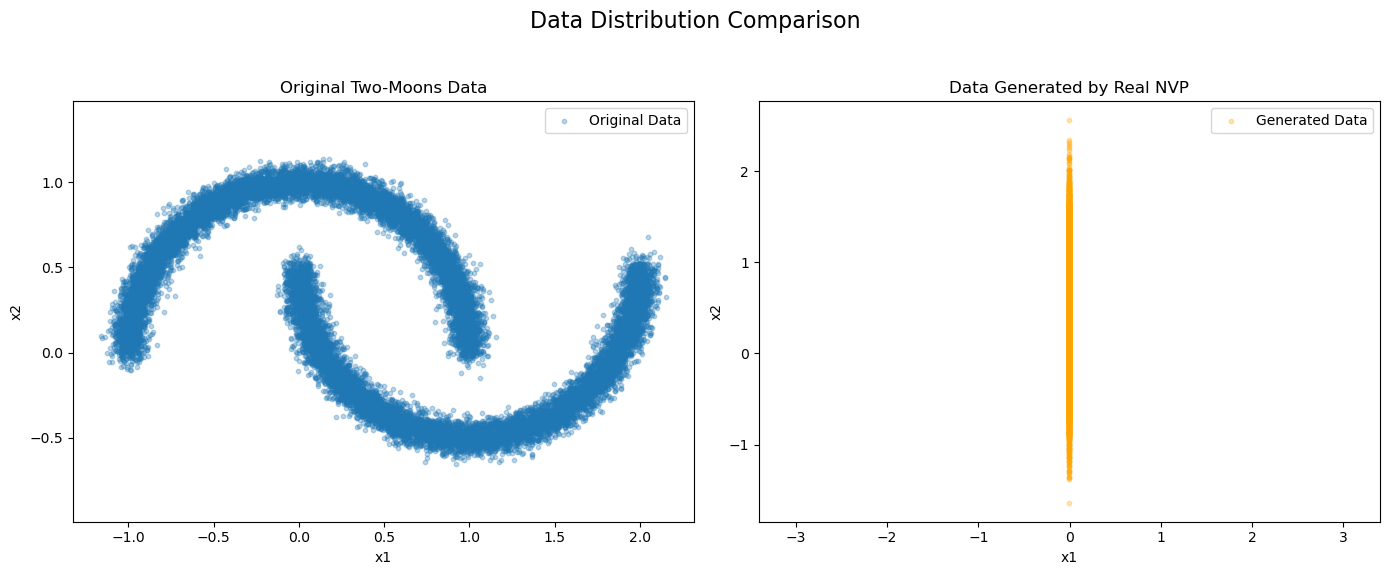

AttributeError: 'NormalizingFlowModel' object has no attribute 'layers'

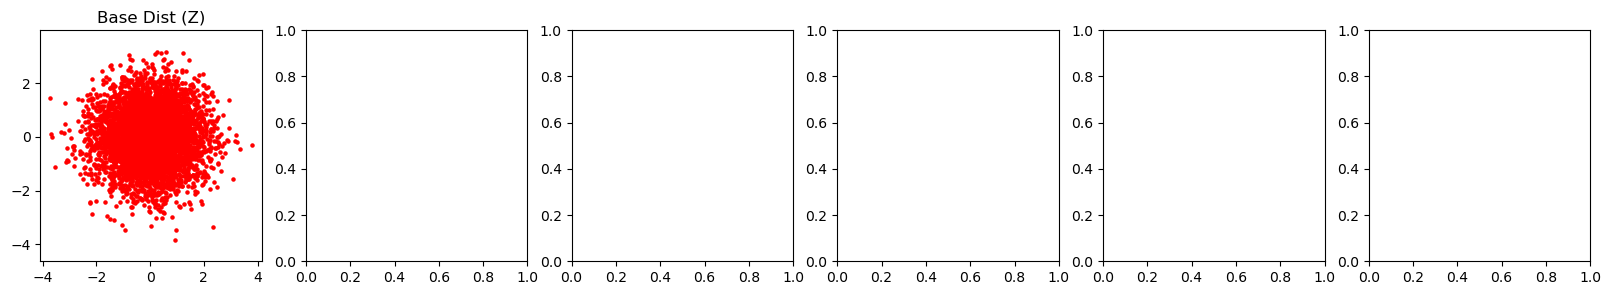

In [7]:
# --- 5. Visualization ---
model.eval()
with torch.no_grad():
    # a) Plot generated samples vs. original data
    plt.figure(figsize=(14, 6))
    
    # Original Data
    plt.subplot(1, 2, 1)
    plt.scatter(data.cpu()[:, 0], data.cpu()[:, 1], s=10, alpha=0.3, label='Original Data')
    plt.title('Original Two-Moons Data')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.axis('equal')

    # Generated Data
    plt.subplot(1, 2, 2)
    # Sample from base distribution
    z_samples = base_dist.sample((n_samples,))
    # Transform to data space
    x_generated, _ = model.forward(z_samples)
    x_generated = x_generated.cpu().numpy()
    plt.scatter(x_generated[:, 0], x_generated[:, 1], s=10, alpha=0.3, c='orange', label='Generated Data')
    plt.title('Data Generated by Real NVP')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.axis('equal')
    
    plt.suptitle('Data Distribution Comparison', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # b) Recreate Figure 18.3: The "flow"
    fig, axes = plt.subplots(1, n_layers + 1, figsize=(20, 3))
    
    # Start with base distribution samples
    z_grid = base_dist.sample((5000,))
    
    # Plot initial distribution
    axes[0].scatter(z_grid.cpu()[:, 0], z_grid.cpu()[:, 1], s=5, c='r')
    axes[0].set_title("Base Dist (Z)")
    axes[0].axis('equal')
    
    x_flow = z_grid
    for i, layer in enumerate(model.layers):
        x_flow, _ = layer.forward(x_flow)
        axes[i + 1].scatter(x_flow.cpu()[:, 0], x_flow.cpu()[:, 1], s=5, c='r')
        axes[i + 1].set_title(f"After Layer {i+1}")
        axes[i + 1].axis('equal')
        
    fig.suptitle('Transformation Flow: Z -> X', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.9])
    plt.show()